# Run level 2A, 2B and 3 pipelines on MRS data using jwst.pipeline classes

### by Patrick Kavanagh (DIAS, Ireland) Feb 2nd 2019

This notebook demonstrates the execution of the level 2A, 2B, and 3 pipelines for MRS data in Python using the jwst.pipeline classes.

For a description of the pipeline classes see:

https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/index.html

The files used in this notebook is a MIRISim simulation of a point source with power-law (alpha=0) plus emission lines spectrum. The simulated observation is a four-point dither on the source with the channels 1 and 2, and the SHORT disperser. 

The steps applied are:

- ramps to slopes pipeline (Detector1Pipeline)

- CALSPEC2 steps and spectral extraction from each dither (Spec2Pipeline)

- combination of dithers and spectral extraction (Spec3Pipeline)

- manual conversion of extracted spectra to Jy 


#### Imports

In [1]:
import os, glob, shutil

import numpy as np
from astropy.io import fits
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from subprocess import call

from jwst import datamodels

# set the CRDS_CONTEXT
os.environ["CRDS_CONTEXT"] = "jwst_0500.pmap"

%matplotlib inline
# %matplotlib notebook # if you want interactive plots

#### Set input, output location and source type
Since we know the simulation is of a point source, we can set the source type metadata to 'POINT' at this stage as that information is used later in spectral extraction. Otherwise, the pipeline will set the default source type for MRS which is 'EXTENDED'

In [2]:
# set input filenames and directory. In this example, the files are located in a folder called 'MRS_demo_data'
input_dir = 'MRS_demo_data'
input_files = glob.glob(os.path.join(input_dir,'*.fits'))

# set the source type as 'POINT'
for f in input_files:
    with datamodels.MIRIRampModel(f) as dm:
        dm.meta.target.source_type = 'POINT'
        dm.save(os.path.join(input_dir, dm.meta.filename))

# set the output directory name
output_dir = input_dir + '_pipelined'

# if the output directory exists, delete it
if os.path.exists(output_dir): shutil.rmtree(output_dir)

# create the output directory
os.mkdir(output_dir)

#### print some information about the input files. We will just look at the first file

In [3]:
# print some info on input file
with fits.open(input_files[0]) as hdulist:
    
    if hdulist[0].header['ORIGIN'] == 'STScI':
        # specific information on instrument/exposure
        identifier = hdulist[0].header['OBS_ID']
        detector = hdulist[0].header['DETECTOR']
        nInts = hdulist[0].header['NINTS']
        nGroups = hdulist[0].header['NGROUPS']
        readPatt = hdulist[0].header['READPATT']
        expTime = hdulist[0].header['EFFEXPTM']
        subArr = hdulist[0].header['SUBARRAY']
        channel = hdulist[0].header['CHANNEL']
        band = hdulist[0].header['BAND']
        print("ID\t\t\t\t Detector\t nInts\t nGrps\t rdPatt\t subAr\t chan.\t band")
        print("--------------------------------------------------------------------------------------------------")
        print("%s\t %s\t %d\t %s\t %s\t %s\t %s\t %s" % (identifier,detector,nInts,nGroups,readPatt,subArr,channel,band))
        print("\n\n")
        
    else:
        # specific information on instrument/exposure
        detector = hdulist[0].header['DETECTOR']
        nInts = hdulist[0].header['NINTS']
        nGroups = hdulist[0].header['NGROUPS']
        readPatt = hdulist[0].header['READPATT']
        expTime = hdulist[0].header['EFFEXPTM']
        subArr = hdulist[0].header['SUBARRAY']
        channel = hdulist[0].header['CHANNEL']
        band = hdulist[0].header['BAND']
        print("ID\t Detector\t nInts\t nGrps\t rdPatt\t chan.\t band")
        print("--------------------------------------------------------------------------------------------------")
        print("MIRISim\t %s\t %d\t %s\t %s\t %s\t %s" % (detector,nInts,nGroups,readPatt,channel,band))
        print("\n\n")

    # fits extension table
    hdulist.info()

ID	 Detector	 nInts	 nGrps	 rdPatt	 chan.	 band
--------------------------------------------------------------------------------------------------
MIRISim	 MIRIFUSHORT	 2	 50	 FAST	 12	 SHORT



Filename: MRS_demo_data/det_image_seq2_MIRIFUSHORT_12SHORTexp1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     110   ()      
  1  SCI           1 ImageHDU        54   (1032, 1024, 50, 2)   float32   
  2  PIXELDQ       1 ImageHDU        11   (1032, 1024)   int32 (rescales to uint32)   
  3  GROUPDQ       1 ImageHDU        11   (1032, 1024, 50, 2)   uint8   
  4  ERR           1 ImageHDU        11   (1032, 1024, 50, 2)   float32   
  5  REFOUT        1 ImageHDU        12   (258, 1024, 50, 2)   float32   
  6  ASDF          1 BinTableHDU     11   1R x 1C   [5469B]   


#### show the last frame of the first integration for each file

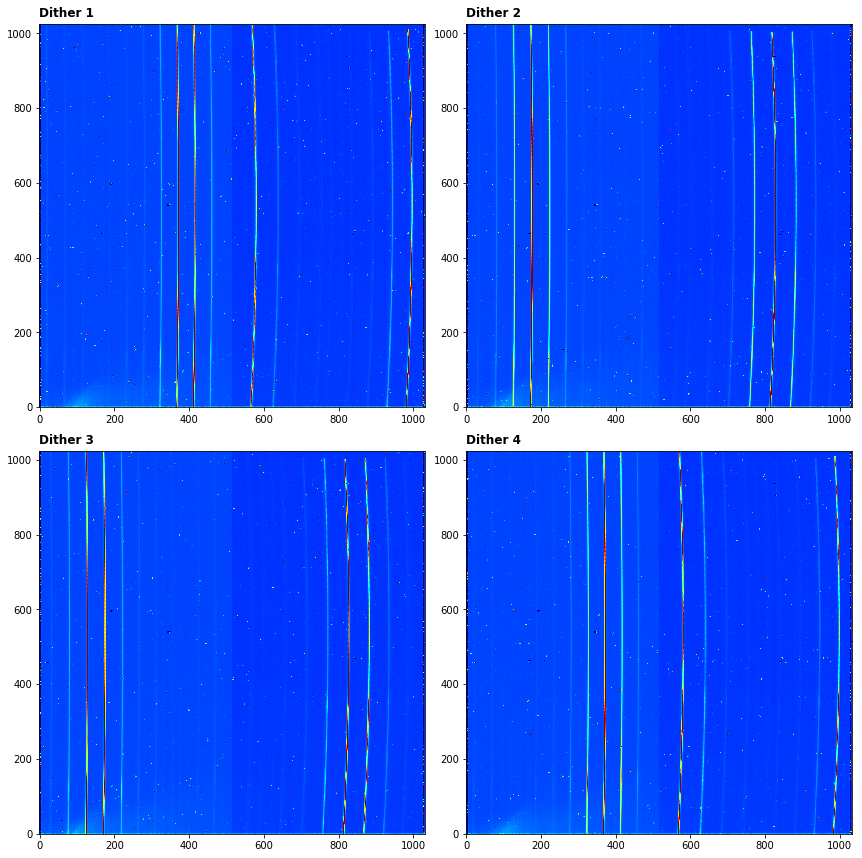

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.ravel()

i = 0
for f in input_files:
    # open the input image as a jwst data model
    with datamodels.MIRIRampModel(f) as in_dm:

        dith_num = i+1
        axs[i].imshow(in_dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=1e4,vmax=1.5e4))
        axs[i].annotate('Dither %d' % dith_num, xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
        axs[i].set_facecolor('black')
        i += 1

plt.tight_layout()
plt.show()

### Level 2A pipeline (ramps-to-slopes)

#### import the level 2A pipeline class and print description

In [5]:
from jwst.pipeline import Detector1Pipeline
print(Detector1Pipeline.__doc__)


    Detector1Pipeline: Apply all calibration steps to raw JWST
    ramps to produce a 2-D slope product. Included steps are:
    group_scale, dq_init, saturation, ipc, superbias, refpix, rscd,
    lastframe, linearity, dark_current, persistence, jump detection,
    ramp_fit, and gain_scale.
    


#### run pipeline
We pass the level 1B files (demo data). We need to explicitly skip the IPC step. The output level 2A files will be saved in the output_dir as '*_rate.fits'

There is an issue currently affecting the pipelining of MIRISim data through the refpix which is being looked into. For now, we just skip this step.


In [6]:
for f in input_files:
    Detector1Pipeline.call(f, output_use_model=True, save_results=True, output_dir=output_dir,
                           steps={'ipc': {'skip': True},
                                  'refpix': {'skip': True}})


2019-02-04 17:42:44,960 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2019-02-04 17:42:44,962 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2019-02-04 17:42:44,964 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2019-02-04 17:42:44,965 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2019-02-04 17:42:44,967 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2019-02-04 17:42:44,969 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2019-02-04 17:42:44,971 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2019-02-04 17:42:44,973 - stpipe.Detector1Pipeline.rscd - INFO - RSCD_Step instance created.
2019-02-04 17:42:44,975 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2019-02-04 17:42:44,977 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2019-02-04 

2019-02-04 17:43:33,557 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 50, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1.fits>,).
2019-02-04 17:43:33,557 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.
2019-02-04 17:43:33,559 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done
2019-02-04 17:43:33,615 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2, 50, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1.fits>,).
2019-02-04 17:43:33,630 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma
2019-02-04 17:43:33,634 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0007.fits
2019-02-04 17:43:33,768 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0034.fits
2019-02-04 17:43:36,496

2019-02-04 17:49:43,509 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...
2019-02-04 17:49:45,763 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(2, 50, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1.fits>,).
2019-02-04 17:49:45,777 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES={} is a power of 2; correction not needed
2019-02-04 17:49:45,778 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped
2019-02-04 17:49:45,779 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done
2019-02-04 17:49:45,840 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(2, 50, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1.fits>,).
2019-02-04 17:49:45,859 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_mask_0022.fits
2019-02-04 17:49:48,174 - stpipe.Detector1Pipeline.

2019-02-04 17:56:24,285 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2019-02-04 17:56:24,286 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2019-02-04 17:56:24,289 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2019-02-04 17:56:24,291 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2019-02-04 17:56:24,293 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2019-02-04 17:56:24,296 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2019-02-04 17:56:24,298 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2019-02-04 17:56:24,300 - stpipe.Detector1Pipeline.rscd - INFO - RSCD_Step instance created.
2019-02-04 17:56:24,302 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2019-02-04 17:56:24,303 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2019-02-04 

2019-02-04 17:57:04,129 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 50, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1.fits>,).
2019-02-04 17:57:04,130 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.
2019-02-04 17:57:04,131 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done
2019-02-04 17:57:04,188 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2, 50, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1.fits>,).
2019-02-04 17:57:04,203 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma
2019-02-04 17:57:04,208 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0007.fits
2019-02-04 17:57:04,312 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0034.fits
2019-02-04 17:57:06,901

2019-02-04 18:03:02,345 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...
2019-02-04 18:03:04,657 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(2, 50, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1.fits>,).
2019-02-04 18:03:04,671 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES={} is a power of 2; correction not needed
2019-02-04 18:03:04,672 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped
2019-02-04 18:03:04,674 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done
2019-02-04 18:03:04,731 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(2, 50, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1.fits>,).
2019-02-04 18:03:04,749 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_mask_0022.fits
2019-02-04 18:03:07,059 - stpipe.Detector1Pipeline.

#### Quick check of the pipeline steps applied in the output. We'll look at the first dither:

In [7]:
level2A_files = glob.glob(os.path.join(output_dir,'*_rate.fits'))

with datamodels.open(level2A_files[0]) as dm:
    # check the calibration step information
    print('Check step information status:')
    print('dq_init: %s' % dm.meta.cal_step.dq_init)
    print('saturation: %s' % dm.meta.cal_step.saturation)
    print('ipc: %s' % dm.meta.cal_step.ipc)
    print('linearity: %s' % dm.meta.cal_step.linearity)
    print('rscd: %s' % dm.meta.cal_step.rscd)
    print('firstframe: %s' % dm.meta.cal_step.firstframe)
    print('lastframe: %s' % dm.meta.cal_step.lastframe)
    print('dark_current: %s' % dm.meta.cal_step.dark_sub)
    print('refpix: %s' % dm.meta.cal_step.refpix)
    print('jump: %s' % dm.meta.cal_step.jump)
    print('ramp_fit: %s' % dm.meta.cal_step.ramp_fit)

Check step information status:
dq_init: COMPLETE
saturation: COMPLETE
ipc: None
linearity: COMPLETE
rscd: COMPLETE
firstframe: COMPLETE
lastframe: COMPLETE
dark_current: COMPLETE
refpix: None
jump: COMPLETE
ramp_fit: COMPLETE


### Level 2B pipeline

#### import the level 2B pipeline class and print description

In [8]:
from jwst.pipeline import Spec2Pipeline
print(Spec2Pipeline.__doc__)


    Spec2Pipeline: Processes JWST spectroscopic exposures from Level 2a to 2b.
    Accepts a single exposure or an association as input.

    Included steps are:
    assign_wcs, background subtraction, NIRSpec MSA imprint subtraction,
    NIRSpec MSA bad shutter flagging, 2-D subwindow extraction, flat field,
    source type decision, straylight, fringe, pathloss, barshadow,  photom,
    resample_spec, cube_build, and extract_1d.
    


#### run pipeline
We pass the level 2A files. The output level 2B files will be saved in the output_dir as '*_cal.fits'. 

Note that since MIRISim does not add straylight, we can skip the straylight correction step.

In [9]:
for f in level2A_files:
    Spec2Pipeline.call(f, output_use_model=True, save_results=True, output_dir=output_dir, 
                       steps={'straylight':{'skip':True}})


2019-02-04 18:09:21,458 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2019-02-04 18:09:21,461 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2019-02-04 18:09:21,466 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2019-02-04 18:09:21,468 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2019-02-04 18:09:21,470 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2019-02-04 18:09:21,472 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.
2019-02-04 18:09:21,475 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.
2019-02-04 18:09:21,477 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.
2019-02-04 18:09:21,479 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.
2019-02-04 18:09:21,481 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.
2019-02-04 18:09:2

2019-02-04 18:09:32,483 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  -0.001065721 -0.000882770 0.000429295 -0.000882770 0.000429295 0.000533304 -0.001065721 0.000533304
2019-02-04 18:09:32,483 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs
2019-02-04 18:09:32,495 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done
2019-02-04 18:09:32,619 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1_rate.fits>,).
2019-02-04 18:09:32,762 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2019-02-04 18:09:33,446 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done
2019-02-04 18:09:33,554 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1_rate.fits>,).
2019-02-04

2019-02-04 18:15:22,412 - stpipe.Spec2Pipeline - INFO - Finished processing product MRS_demo_data_pipelined/det_image_seq4_MIRIFUSHORT_12SHORTexp1
2019-02-04 18:15:22,413 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2019-02-04 18:15:23,559 - stpipe.Spec2Pipeline - INFO - Saved model in MRS_demo_data_pipelined/det_image_seq4_MIRIFUSHORT_12SHORTexp1_cal.fits
2019-02-04 18:15:23,560 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2019-02-04 18:15:23,573 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2019-02-04 18:15:23,575 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2019-02-04 18:15:23,577 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2019-02-04 18:15:23,578 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2019-02-04 18:15:23,580 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2019-02-04 18:15:23,581 - stpipe.Spec2Pipeline.extract_2d 

2019-02-04 18:15:33,080 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /anaconda3/envs/jwst7.2.1/lib/python3.6/site-packages/gwcs/selector.py:444: RuntimeWarning: invalid value encountered in less_equal
  temp = np.where(np.logical_or(temp <= val_range[0],

2019-02-04 18:15:33,082 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /anaconda3/envs/jwst7.2.1/lib/python3.6/site-packages/gwcs/selector.py:445: RuntimeWarning: invalid value encountered in greater_equal
  temp >= val_range[1]),

2019-02-04 18:15:33,366 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  -0.000494345 -0.000719915 0.001000671 -0.000719915 0.001000671 0.000696159 -0.000494345 0.000696159
2019-02-04 18:15:33,367 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs
2019-02-04 18:15:33,377 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done
2019-02-04 18:15:33,511 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from de

2019-02-04 18:21:14,122 - stpipe.Spec2Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_extract1d_0003.json
2019-02-04 18:21:14,147 - stpipe.Spec2Pipeline.extract_1d - INFO - source_type = point
2019-02-04 18:21:22,622 - stpipe.Spec2Pipeline.extract_1d - INFO - Data have been flux calibrated; setting net to 0.
2019-02-04 18:21:22,667 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done
2019-02-04 18:21:22,668 - stpipe.Spec2Pipeline - INFO - Finished processing product MRS_demo_data_pipelined/det_image_seq2_MIRIFUSHORT_12SHORTexp1
2019-02-04 18:21:22,668 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2019-02-04 18:21:23,716 - stpipe.Spec2Pipeline - INFO - Saved model in MRS_demo_data_pipelined/det_image_seq2_MIRIFUSHORT_12SHORTexp1_cal.fits
2019-02-04 18:21:23,716 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2019-02-04 18:21:23,730 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instanc

2019-02-04 18:21:33,762 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /anaconda3/envs/jwst7.2.1/lib/python3.6/site-packages/gwcs/selector.py:444: RuntimeWarning: invalid value encountered in less_equal
  temp = np.where(np.logical_or(temp <= val_range[0],

2019-02-04 18:21:33,763 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /anaconda3/envs/jwst7.2.1/lib/python3.6/site-packages/gwcs/selector.py:445: RuntimeWarning: invalid value encountered in greater_equal
  temp >= val_range[1]),

2019-02-04 18:21:34,021 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  -0.001096081 -0.000902884 0.000398935 -0.000902884 0.000398935 0.000513191 -0.001096081 0.000513191
2019-02-04 18:21:34,022 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs
2019-02-04 18:21:34,031 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done
2019-02-04 18:21:34,171 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from de

2019-02-04 18:27:10,374 - stpipe.Spec2Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_extract1d_0003.json
2019-02-04 18:27:10,394 - stpipe.Spec2Pipeline.extract_1d - INFO - source_type = point
2019-02-04 18:27:19,112 - stpipe.Spec2Pipeline.extract_1d - INFO - Data have been flux calibrated; setting net to 0.
2019-02-04 18:27:19,155 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done
2019-02-04 18:27:19,156 - stpipe.Spec2Pipeline - INFO - Finished processing product MRS_demo_data_pipelined/det_image_seq1_MIRIFUSHORT_12SHORTexp1
2019-02-04 18:27:19,157 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2019-02-04 18:27:20,199 - stpipe.Spec2Pipeline - INFO - Saved model in MRS_demo_data_pipelined/det_image_seq1_MIRIFUSHORT_12SHORTexp1_cal.fits
2019-02-04 18:27:20,199 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2019-02-04 18:27:20,212 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instanc

2019-02-04 18:27:30,209 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /anaconda3/envs/jwst7.2.1/lib/python3.6/site-packages/gwcs/selector.py:444: RuntimeWarning: invalid value encountered in less_equal
  temp = np.where(np.logical_or(temp <= val_range[0],

2019-02-04 18:27:30,211 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /anaconda3/envs/jwst7.2.1/lib/python3.6/site-packages/gwcs/selector.py:445: RuntimeWarning: invalid value encountered in greater_equal
  temp >= val_range[1]),

2019-02-04 18:27:30,480 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  -0.000464153 -0.000699485 0.001030863 -0.000699485 0.001030863 0.000716590 -0.000464153 0.000716590
2019-02-04 18:27:30,480 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs
2019-02-04 18:27:30,489 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done
2019-02-04 18:27:30,646 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from de

2019-02-04 18:33:07,103 - stpipe.Spec2Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_extract1d_0003.json
2019-02-04 18:33:07,124 - stpipe.Spec2Pipeline.extract_1d - INFO - source_type = point
2019-02-04 18:33:15,644 - stpipe.Spec2Pipeline.extract_1d - INFO - Data have been flux calibrated; setting net to 0.
2019-02-04 18:33:15,690 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done
2019-02-04 18:33:15,690 - stpipe.Spec2Pipeline - INFO - Finished processing product MRS_demo_data_pipelined/det_image_seq3_MIRIFUSHORT_12SHORTexp1
2019-02-04 18:33:15,691 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2019-02-04 18:33:16,721 - stpipe.Spec2Pipeline - INFO - Saved model in MRS_demo_data_pipelined/det_image_seq3_MIRIFUSHORT_12SHORTexp1_cal.fits
2019-02-04 18:33:16,722 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


### check of output

The level 2B pipeline for the MRS produces three files for each input:

_cal.fits - the calibrated level 2B file from each dither

_s3d.fits - the cube from each dither

_x1d.fits - the 1d spectrum from each dither


In [10]:
# set the output file names
level2B_files = glob.glob(os.path.join(output_dir,'*_cal.fits'))
cube_files = glob.glob(os.path.join(output_dir,'*_s3d.fits'))

#### level 2B file

In [11]:
with datamodels.open(level2B_files[0]) as dm:
    # check the calibration step information
    print('Check step information status:')
    print('assign_wcs: %s' % dm.meta.cal_step.assign_wcs)
    print('flat_field: %s' % dm.meta.cal_step.flat_field)
    print('srctype: %s' % dm.meta.cal_step.srctype)
    print('straylight: %s' % dm.meta.cal_step.straylight)
    print('fringe: %s' % dm.meta.cal_step.fringe)
    print('photom: %s' % dm.meta.cal_step.photom)


Check step information status:
assign_wcs: COMPLETE
flat_field: COMPLETE
srctype: COMPLETE
straylight: None
fringe: COMPLETE
photom: COMPLETE


#### Look at level 1B and calibrated level 2B image. We'll look at the first dither only

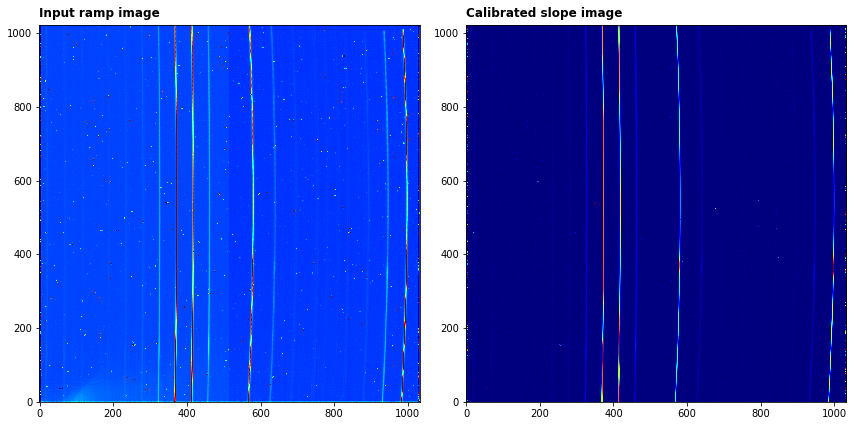

In [12]:
# open the input image as a jwst data model
with datamodels.MIRIRampModel(input_files[0]) as in_dm:
    with datamodels.open(level2B_files[0]) as out_dm:
        
        # plot--------------------------------------
        # show the input ramp image and the calibrated
        # slope image. Note the user may have to adjust
        # the scale parameters
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))

        # sum the groups in the first integration of the input ramp image and plot
        axs[0].imshow(in_dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=1e4,vmax=1.5e4))
        axs[0].annotate('Input ramp image', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
        axs[0].set_facecolor('black')
        axs[1].imshow(out_dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=0, vmax=500)
        axs[1].annotate('Calibrated slope image', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
        axs[1].set_facecolor('black')

        plt.tight_layout()
        plt.show()

#### Look at cube file. We'll look at the first dither only

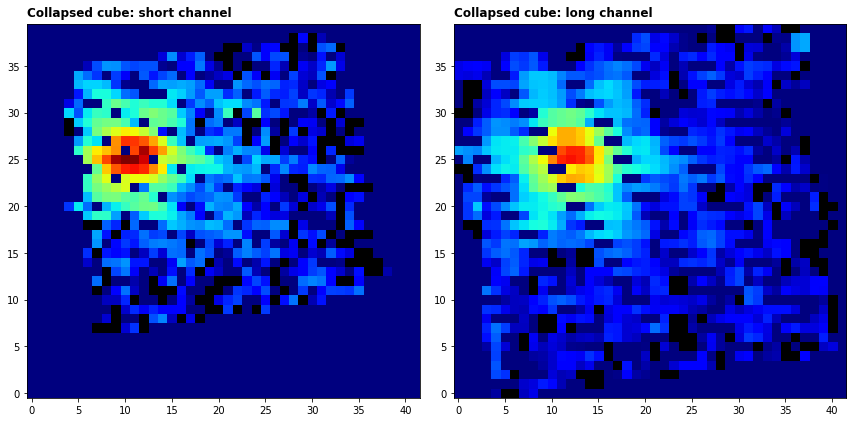

In [13]:
# open the cube as a jwst data model
with datamodels.open(cube_files[0]) as cube_dm:
    
    # plot--------------------------------------
    # sum some of the the frames in each channel
    # Note the user may have to adjust the scaling
    # parameters
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].imshow(np.sum(cube_dm.data[100:300], axis=0), cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=10,vmax=1e5))
    axs[0].annotate('Collapsed cube: short channel', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
    axs[0].set_facecolor('black')
    axs[1].imshow(np.sum(cube_dm.data[3000:3200], axis=0), cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=10,vmax=1e5))
    axs[1].annotate('Collapsed cube: long channel', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
    axs[1].set_facecolor('black')
    
    plt.tight_layout()
    plt.show()

### Level 3 pipeline

We first create an association file in the output directory containing the list of level 2B files ("_cal.fits") produced by the level 2B pipeline. 

#### create the level 3 association using the asn_from_list tool

In [14]:
call(["asn_from_list", "-o", "MRS_asn.json"] + level2B_files + ["--product-name", "dither"])


0

In [15]:
from jwst.pipeline import Spec3Pipeline
print(Spec3Pipeline.__doc__)



    Spec3Pipeline: Processes JWST spectroscopic exposures from Level 2b to 3.

    Included steps are:
    MIRI MRS background matching (skymatch)
    outlier detection (outlier_detection)
    2-D spectroscopic resampling (resample_spec)
    3-D spectroscopic resampling (cube_build)
    1-D spectral extraction (extract_1d)
    


The extracted spectra are in units of mJy/arcsec^2. To convert these to mJy we multiply by the spaxel area.

Note that an additional aperture correction factor for the encircled energy in the aperture should also be applied but we forego this here since the CDPs are currently not available.

The mrs_imatch step does not appear to be working very well at the moment so we will skip this step for now.

In [16]:
# read the association and run
dms = datamodels.open("MRS_asn.json")
Spec3Pipeline.call(dms, save_results=True, output_dir=output_dir,
                  steps={'cube_build': {'save_results': True, 'output_dir': output_dir},
                         'extract_1d': {'save_results': True, 'output_dir': output_dir},
                         'mrs_imatch': {'skip': True}})


2019-02-04 18:33:35,183 - stpipe.Spec3Pipeline - INFO - Spec3Pipeline instance created.
2019-02-04 18:33:35,184 - stpipe.Spec3Pipeline.mrs_imatch - INFO - MRSIMatchStep instance created.
2019-02-04 18:33:35,187 - stpipe.Spec3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2019-02-04 18:33:35,189 - stpipe.Spec3Pipeline.resample_spec - INFO - ResampleSpecStep instance created.
2019-02-04 18:33:35,191 - stpipe.Spec3Pipeline.cube_build - INFO - CubeBuildStep instance created.
2019-02-04 18:33:35,192 - stpipe.Spec3Pipeline.extract_1d - INFO - Extract1dStep instance created.
2019-02-04 18:33:35,389 - stpipe.Spec3Pipeline - INFO - Step Spec3Pipeline running with args (<ModelContainer>,).
2019-02-04 18:33:40,088 - stpipe.Spec3Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq2_MIRIFUSHORT_12SHORTexp1_cal.fits' reftypes = ['cubepar', 'drizpars', 'extract1d', 'resol']
2019-02-04 18:33:40,092 - stpipe.Spec3Pipeline - INFO - Prefetch for CUBEPAR re

2019-02-04 18:34:01,517 - stpipe.Spec3Pipeline.outlier_detection - INFO - Working on next Single IFU Cube  = 1
2019-02-04 18:34:41,519 - stpipe.Spec3Pipeline.outlier_detection - INFO - IFUChannel 1
2019-02-04 18:34:41,584 - stpipe.Spec3Pipeline.outlier_detection - INFO - Time Create Single ifucube  = 40.1.s
2019-02-04 18:34:41,585 - stpipe.Spec3Pipeline.outlier_detection - INFO - Working on next Single IFU Cube  = 2
2019-02-04 18:35:21,716 - stpipe.Spec3Pipeline.outlier_detection - INFO - IFUChannel 1
2019-02-04 18:35:21,779 - stpipe.Spec3Pipeline.outlier_detection - INFO - Time Create Single ifucube  = 40.2.s
2019-02-04 18:35:21,780 - stpipe.Spec3Pipeline.outlier_detection - INFO - Working on next Single IFU Cube  = 3
2019-02-04 18:36:01,826 - stpipe.Spec3Pipeline.outlier_detection - INFO - IFUChannel 1
2019-02-04 18:36:01,891 - stpipe.Spec3Pipeline.outlier_detection - INFO - Time Create Single ifucube  = 40.1.s
2019-02-04 18:36:01,892 - stpipe.Spec3Pipeline.outlier_detection - INFO -

2019-02-04 18:43:06,027 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  MIN & Max (microns)
2019-02-04 18:43:06,027 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 3   645   1.00   7.48999972   0.00200000   7.48999972   8.77999978
2019-02-04 18:43:06,028 - stpipe.Spec3Pipeline.cube_build - INFO - Cube covers channel, subchannel: 2 short 
2019-02-04 18:43:06,028 - stpipe.Spec3Pipeline.cube_build - INFO - Output Name MRS_demo_data_pipelined/dither_ch2-short_s3d.fits
2019-02-04 18:43:06,658 - stpipe.Spec3Pipeline.cube_build - INFO - Time to transform pixels to output frame = 0.6.s
2019-02-04 18:43:44,323 - stpipe.Spec3Pipeline.cube_build - INFO - Time to match file to ifucube = 37.7.s
2019-02-04 18:43:44,972 - stpipe.Spec3Pipeline.cube_build - INFO - Time to transform pixels to output frame = 0.6.s
2019-02-04 18:44:23,965 - stpipe.Spec3Pipeline.cube_build - INFO - Time to match file to ifucube = 39.0.s
2019-02-04 18:44:24,712 - stpipe.Spec3Pipe

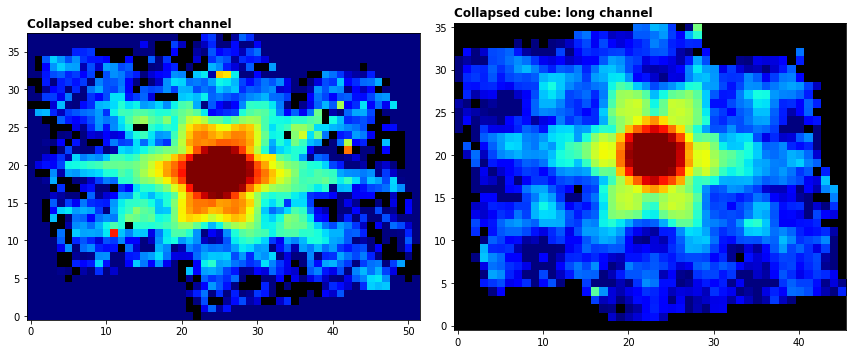

In [17]:
cube_files = sorted(glob.glob(os.path.join(output_dir, 'dither*s3d.fits')))
ch1_cdm = datamodels.open(cube_files[0])
ch2_cdm = datamodels.open(cube_files[1])

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(np.sum(ch1_cdm.data[100:-100], axis=0), cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=40,vmax=1e4))
axs[0].annotate('Collapsed cube: short channel', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[0].set_facecolor('black')
axs[1].imshow(np.sum(ch2_cdm.data[100:-100], axis=0), cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=40,vmax=1e4))
axs[1].annotate('Collapsed cube: long channel', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[1].set_facecolor('black')

plt.tight_layout()
plt.show()


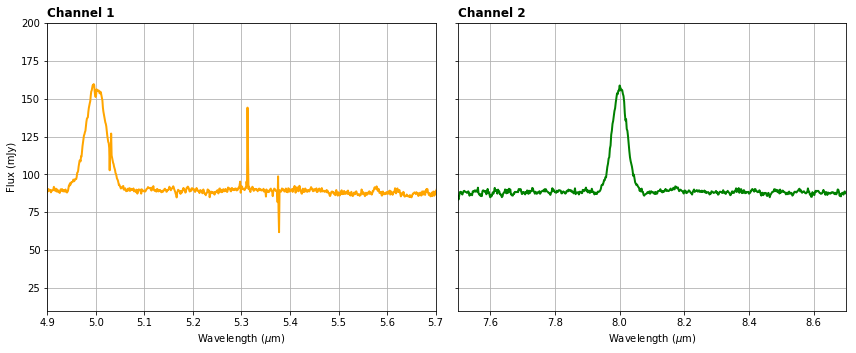

In [18]:
spec_files = sorted(glob.glob(os.path.join(output_dir, 'dither*1d.fits')))
ch1_sdm = datamodels.open(spec_files[0])
ch2_sdm = datamodels.open(spec_files[1])

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# plot the spectrum in the channel 2 wavelength range
spaxel_area = ch1_cdm.meta.wcsinfo.cdelt1 * ch1_cdm.meta.wcsinfo.cdelt2 * 3600**2
axs[0].plot(ch1_sdm.spec[0].spec_table['WAVELENGTH'], ch1_sdm.spec[0].spec_table['FLUX'] * spaxel_area, c='orange', marker='.', markersize=0, linestyle='-', linewidth=2)
axs[0].set_ylabel(r'Flux (mJy)')
axs[0].set_xlabel(r'Wavelength ($\mu$m)')
axs[0].set_xlim(4.9,5.7)
axs[0].set_ylim(10,200)

spaxel_area = ch2_cdm.meta.wcsinfo.cdelt1 * ch2_cdm.meta.wcsinfo.cdelt2 * 3600**2
axs[1].plot(ch2_sdm.spec[0].spec_table['WAVELENGTH'], ch2_sdm.spec[0].spec_table['FLUX']  * spaxel_area, c='g', marker='.', markersize=0, linestyle='-', linewidth=2)
axs[1].set_xlabel(r'Wavelength ($\mu$m)')
axs[1].set_xlim(7.5,8.7)

axs[1].annotate('Channel 2', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[0].annotate('Channel 1', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[0].grid()
axs[1].grid()

plt.tight_layout()
plt.show()